**Neural Network Just Using numpy**
This a code of a neural network made with just numpy and tested on MNIST dataset

## 1-) Download the dataset 
Download the dataset and turn it into a numpy array for future use

In [95]:
import numpy as np
from matplotlib import pyplot as plt
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hojjatk/mnist-dataset")
with open(path + r'/t10k-images.idx3-ubyte','rb') as f:
    raw_data = f.read()
np_data = np.frombuffer(raw_data, dtype=np.uint8)
with open(path + r'/t10k-labels.idx1-ubyte','rb') as f:
    raw_labels=f.read()
np_labels = np.frombuffer(raw_labels, dtype=np.uint8)

In [101]:
data = np_data[16:].reshape(10000, 28*28)

labels = np_labels[8:].reshape(10000, 1)

data = np.hstack((labels, data))
print(data.shape)
m , n =data.shape
np.random.shuffle(data)

data_test = data[0:2000].T
X_test = data_test[1:n]
Y_test = data_test[0]
X_test = X_test/255

data_train = data[2000:m].T
X_train=data_train[1:n]
Y_train=data_train[0]
X_train = X_train / 255
_,m_train = X_train.shape

Y_train.max()+1

(10000, 785)


np.uint8(10)

In [122]:
def init_params():
    W1 = np.random.rand(10, 784) * np.sqrt(2/784)
    b1 = np.random.rand(10, 1) *0.5
    W2 = np.random.rand(10, 10) * np.sqrt(2/10)
    b2 = np.random.rand(10, 1) *0.5
    return W1, b1, W2, b2

def Relu(Z):
    return np.maximum(0,Z)
def softmax(Z):
    Z_shifted = Z - np.max(Z, axis=0, keepdims=True)
    exp_values = np.exp(Z_shifted)
    return exp_values / np.sum(exp_values, axis=0, keepdims=True)

def foward_prop(W1, b1, W2, b2, X):
    Z1 = np.dot(W1, X) + b1
    A1 = Relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2
    
def ReLU_deriv(Z):
    return Z > 0

def one_hot_encode(Y):
    one_hot_Y = np.zeros((Y.size, 10))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def calculate_loss(A2, Y):
    m = Y.shape[1] if len(Y.shape) > 1 else Y.size
    epsilon = 1e-15
    A2_safe = np.clip(A2, epsilon, 1-epsilon)
    if len(Y.shape) == 1 or Y.shape[0] == 1:
        Y = Y.flatten()
        loss = -np.sum(np.log(A2_safe[Y, range(m)])) / m
    else:
        loss = -np.sum(Y * np.log(A2_safe)) / m
    return loss
    

def compute_cost(A2, Y):
    m= Y.shape[0]
    cost = -1/m * np.sum(Y* np.log(A2))
    return cost

def backwards_prop(Z1, A1, Z2, A2, W1, W2, X, Y,lambda_reg):
    one_hot_encode_Y =one_hot_encode(Y)
    m= Y.size
    
    dZ2 = A2 - one_hot_encode_Y
    dW2 = 1/m * np.dot(dZ2, A1.T) + (lambda_reg/m)*W2
    db2 = 1/m * np.sum(dZ2, axis=1, keepdims=True)   
    
    dZ1 = np.dot(W2.T , dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)  + (lambda_reg/m)*W1
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True)
    
    return dW1, db1, dW2, db2    

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2


In [ ]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def create_mini_batches(X,Y,batch_size):
    m = X.shape[1]
    mini_batches = []
    
    permutation = np.random.permutation(m)
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[permutation]
    
    num_complete_minibatches = m // batch_size
    
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * batch_size : (k + 1) * batch_size]
        mini_batch_Y = shuffled_Y[k * batch_size : (k + 1) * batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    if m % batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

def gradient_descent_with_mini_batches(X, Y, alpha, iterations, batch_size , lambda_reg):
    m=X.shape[1]
    W1 , b1, W2, b2 = init_params()
    
    for i in range(iterations):
        # Create random minibatches
        mini_batches = create_mini_batches(X, Y, batch_size)
        
        for mini_batch in mini_batches:
            # Get X_mini and Y_mini from mini_batch
            X_mini, Y_mini = mini_batch
            mini_m = X_mini.shape[1]  # number of examples in mini-batch

            Z1, A1, Z2, A2 = foward_prop(W1, b1, W2, b2, X_mini)
            
            dW1, db1, dW2, db2 = backwards_prop(Z1, A1, Z2, A2, W1, W2, X_mini, Y_mini, lambda_reg)
            
            # Update parameters
            W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        
        if i % 10 == 0:
            Z1, A1, Z2, A2 = foward_prop(W1, b1, W2, b2, X)
            cost = compute_cost(A2, Y)
            predictions = get_predictions(A2)
            accuracy = get_accuracy(predictions, Y)
            loss = calculate_loss(A2, Y)
            print(f"Iteration: {i}, Cost: {cost}, Accuracy: {accuracy}, Loss: {loss}")
    
    return W1, b1, W2, b2

    



In [135]:
W1, b1, W2, b2 = gradient_descent_with_mini_batches(X_train, Y_train, 0.01, 500,64, 0.05)


[0 0 0 ... 2 3 3] [0 0 0 ... 1 3 0]
Iteration: 0, Cost: 103.67317331009481, Accuracy: 0.387125, Loss: 2.0696012056085817
[0 0 0 ... 1 3 0] [0 0 0 ... 1 3 0]
Iteration: 10, Cost: 218.615172457469, Accuracy: 0.860125, Loss: 0.5318942429350504
[0 0 0 ... 1 3 0] [0 0 0 ... 1 3 0]
Iteration: 20, Cost: 275.07341398184616, Accuracy: 0.89225, Loss: 0.3863558134083404
[0 0 0 ... 1 3 0] [0 0 0 ... 1 3 0]
Iteration: 30, Cost: 304.12835101188256, Accuracy: 0.907, Loss: 0.33132708575059666
[0 0 0 ... 1 3 0] [0 0 0 ... 1 3 0]
Iteration: 40, Cost: 323.07754468908786, Accuracy: 0.913375, Loss: 0.3013125013566798
[0 0 0 ... 1 3 0] [0 0 0 ... 1 3 0]
Iteration: 50, Cost: 337.1409078102869, Accuracy: 0.920375, Loss: 0.27970370818352636
[0 0 0 ... 1 3 0] [0 0 0 ... 1 3 0]
Iteration: 60, Cost: 347.161433357692, Accuracy: 0.9255, Loss: 0.2642894533371886
[0 0 0 ... 1 3 0] [0 0 0 ... 1 3 0]
Iteration: 70, Cost: 356.1875853268202, Accuracy: 0.92775, Loss: 0.2506206122456852
[0 0 0 ... 1 3 0] [0 0 0 ... 1 3 0]


In [136]:
def get_predictions(A2):
    return np.argmax(A2, axis=0)
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = foward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

In [138]:
dev_predictions = make_predictions(X_test, W1, b1, W2, b2)
get_accuracy(dev_predictions, Y_test)

[1 3 6 ... 9 3 8] [1 3 6 ... 9 8 8]


np.float64(0.9215)

Prediction:  [9]
Label:  9


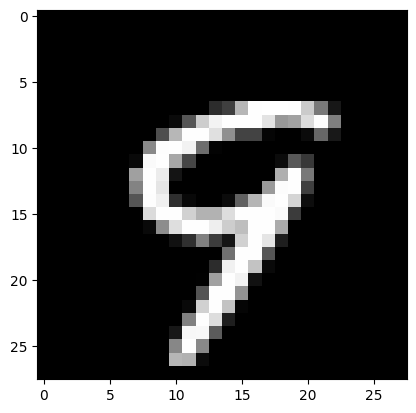

Prediction:  [0]
Label:  0


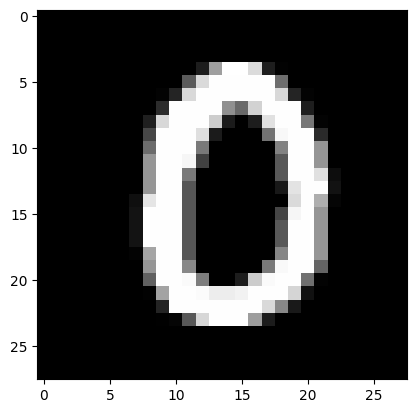

Prediction:  [0]
Label:  0


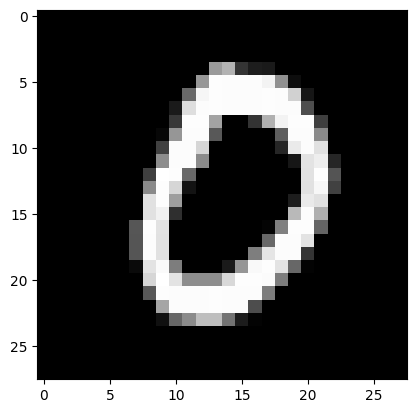

Prediction:  [0]
Label:  0


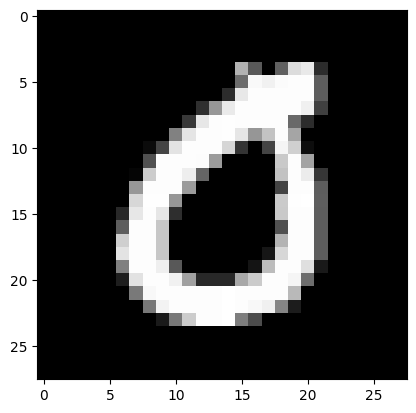

In [129]:
test_prediction(4, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)